# Predict the magnitude of the next eathquake

In [1]:
import Utils
import pydoc
from Utils import DataSet
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras import optimizers
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.pyplot import cm
import pandas as pd
import numpy as np

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Name of current file

In [2]:
current_file = 'mag-disc'
setting = 0

# Settings, formatData:

| **config:** (input data)                                                                                |
|---------------------------------------------------------------------------------------------------------|
| **0: Includes (9 features)** | **1: Includes (9 + 4 = 13 features)** | **2: Includes (9 + 4 + 9 = 22 features)** |
| - Time                     | - Latitude                          | - Eigenvalue, 3 values               |
| - Magnitude                | - Longitude                         | - Plunge, 3 values                   |
| - Moment Tensor Exponent   | - Depth                             | - Azimuth, 3 values                  |
| - Moment Tensor, 6 values  | - Scalar moment                     |                                      |



## Variable input

In [3]:
call = []
call.append([])
call.append([EarlyStopping(patience=2)])

In [4]:
act, day, epo, cal, ear = Utils.experiment_settings(setting)

activation = act
maxdays = day
epochs = epo
callbacks = call[cal]
early = ear

## Constant in experiments

In [5]:
scale = 1
shape = 1
categories_in = 10
categories_out = 10

## Get data from database, and format predictors and target

In [6]:
ds = DataSet('1972/01/01', '2019/01/01', maxdays=maxdays)

Created new DataSet containing 2157 seismic events, ( will be using 2155 )
Radius: 1000  km
Center: 46 °, 151 °
From: 1972/01/01 
To: 2019/01/01


## Predictors

In [7]:
n_predictors = 0
predict_txt = []
for k in range(3):
    exec(f'predictors{n_predictors} = ds.formatData(config={k}, norm=scale, shape=shape)')
    exec(f'predict_txt.append(\"Data config {k}: predictors{n_predictors} - input values \
between -1 and 1\")')
    print(predict_txt[n_predictors])
    n_predictors += 1
    exec(f'predictors{n_predictors} = ds.formatDataDiscrete(categories=categories_in, \
    config={k}, norm=scale, shape=shape)')
    exec(f'predict_txt.append(\"Data config {k}: predictors{n_predictors} - discrete input \
values ({categories_in} categories)\")')
    print(predict_txt[n_predictors])
    n_predictors += 1

Data config 0: predictors0 - input values between -1 and 1
Data config 0: predictors1 - discrete input values (10 categories)
Data config 1: predictors2 - input values between -1 and 1
Data config 1: predictors3 - discrete input values (10 categories)
Data config 2: predictors4 - input values between -1 and 1
Data config 2: predictors5 - discrete input values (10 categories)


In [8]:
pred_shape = []

for k in range(n_predictors):
    exec(f'pred_shape.append(predictors{k}.shape[2])')
print("Feature size of predictors:", pred_shape)

Feature size of predictors: [9, 90, 13, 130, 22, 220]


## Targets

In [9]:
n_targets = 1
target_txt = []
target_txt.append('targets0 - Predict the magitude of the next earthquake. Divide output into ' + \
str(categories_out) + ' categories.')
print(target_txt[0])
targets0 = ds.gt_mag_disc(categories=categories_out)

targets0 - Predict the magitude of the next earthquake. Divide output into 10 categories.


# Split data for training and testing

In [10]:
splitat = int(len(predictors0) * .7)
for k in range(n_predictors):
    exec(f'input_train{k}, input_test{k} = predictors{k}[ : splitat] , predictors{k}[splitat : ]')
for k in range(n_targets):
    exec(f'output_train{k}, output_test{k} = targets{k}[ : splitat] , targets{k}[splitat : ]')

# Train and test

In [11]:
for i in range(n_predictors):
    for j in range(n_targets):
        exec(f'model{i}{j} = Sequential()')
        exec(f'model{i}{j}.add(LSTM((100), return_sequences=False, use_bias=True, \
        input_shape=(1, pred_shape[{i}])))')
        exec(f'model{i}{j}.add(Dense(categories_out, activation=activation))')
        exec(f'model{i}{j}.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'mae\'])')
        exec(f'model_training{i}{j} = model{i}{j}.fit(input_train{i}, output_train{j}, \
        validation_data = (input_test{i}, output_test{j}), epochs = epochs, \
        verbose = 0, callbacks = callbacks)')

# Analyze learning

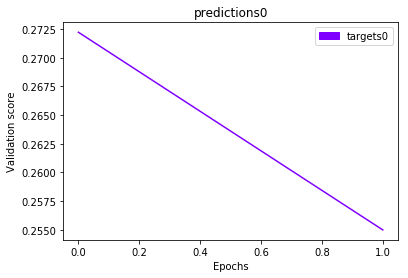

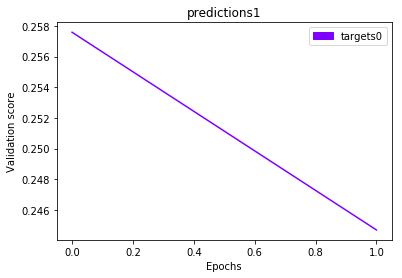

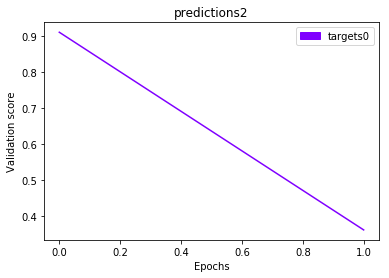

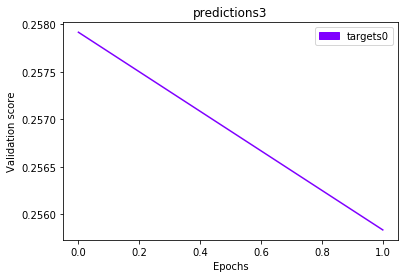

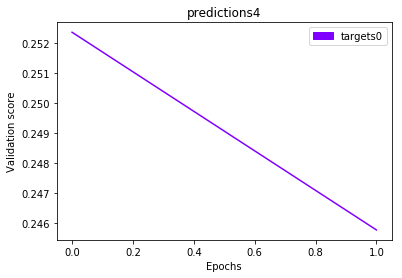

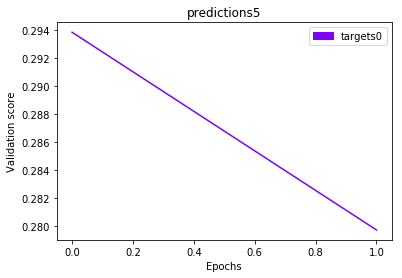

In [12]:
p = []

for i in range(n_predictors):
       
    patches = []
    title = 'predictions' + str(i)
    color = iter(cm.rainbow(np.linspace(0,1,n_targets)))
    for j in range(n_targets):
        c = next(color)
        exec(f'plt.plot(model_training{i}{j}.history[\'val_loss\'], c=c)')
        exec(f'p.append(mpatches.Patch(color=c, label=\'targets{j}\'))')
        patches.append(p[j])

    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Validation score')

    plt.legend(handles=patches)

    plt.show()

## Predict based on model

In [13]:
for i in range(n_predictors):
    for j in range(n_targets):
        exec(f'modpred{i}{j} = model{i}{j}.predict(input_test{i})')

# Plot raw output

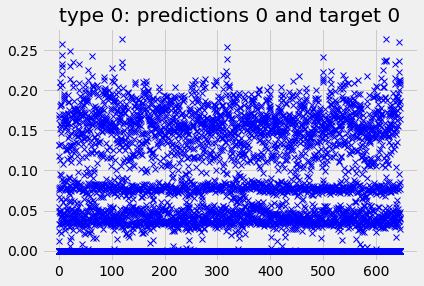

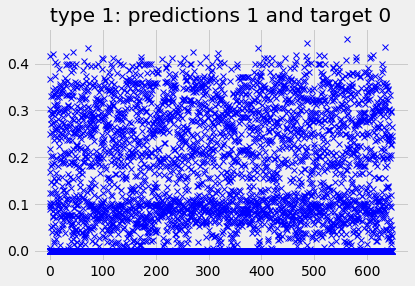

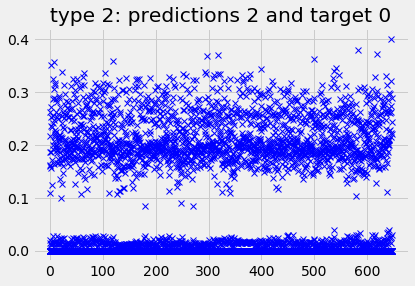

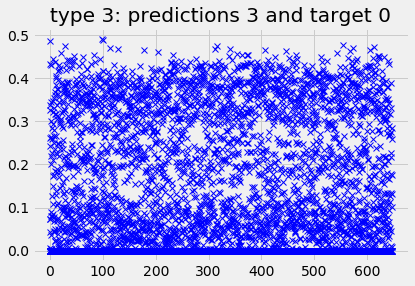

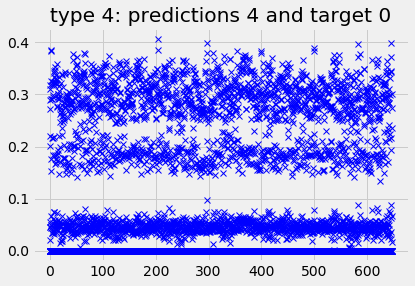

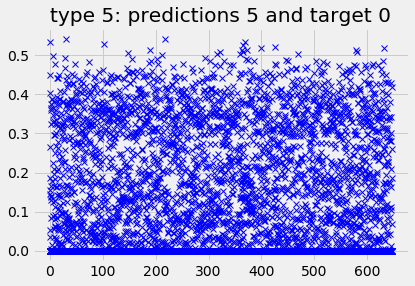

In [14]:
plt.style.use('fivethirtyeight')
types = []
n_types = 0

for i in range(n_predictors):
    for j in range(n_targets):
        title = 'type ' + str(i) + ': predictions ' + str(i) + ' and target ' + str(j)
        exec(f'plt.plot(modpred{i}{j}[:],"bx")')
        types.append(title)
        plt.title(title)
        plt.show()
        n_types += 1

# Measure accuracy

## Create set based on normal distributed average

(Baseline)

In [15]:
n_dummy = 10
dummyset = ds.getGroundTruthNextMag()
minim = min(dummyset)
maxim = max(dummyset)

In [16]:
dummy = []
dummy_disc = []

for i in range(n_dummy):
    dummy.append(Utils.S_model_Predict(dummyset, enable_random_normal=True))
    dummy[i] = dummy[i][splitat : ]
    dummy_disc.append(Utils.getDiscr3t3(categories_out, dummy[i], minim, maxim))

## Plot baseline prediction

In [17]:
perc_avg_list = []

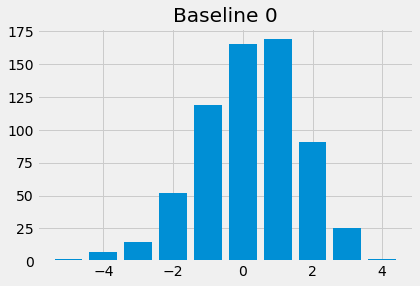

Number of correct: 165
Number of wrong: 482
Percent correct: 26%


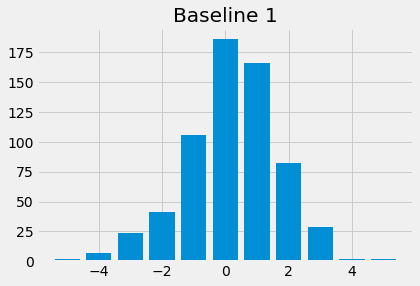

Number of correct: 186
Number of wrong: 461
Percent correct: 29%


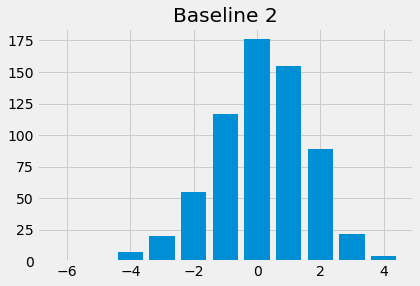

Number of correct: 176
Number of wrong: 471
Percent correct: 27%


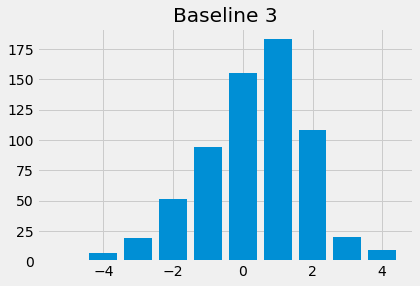

Number of correct: 155
Number of wrong: 492
Percent correct: 24%


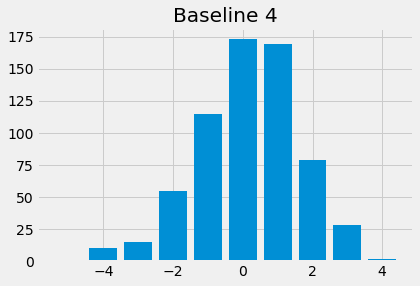

Number of correct: 173
Number of wrong: 474
Percent correct: 27%


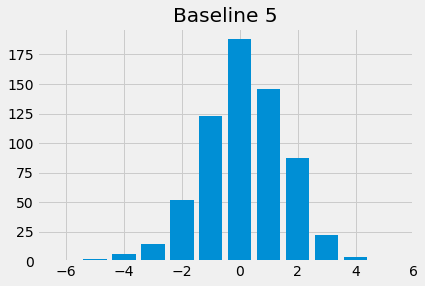

Number of correct: 188
Number of wrong: 459
Percent correct: 29%


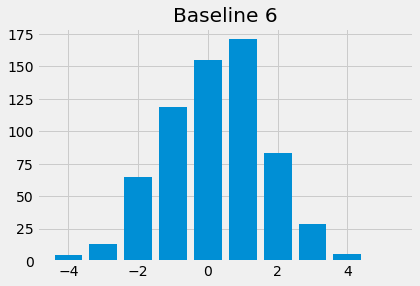

Number of correct: 155
Number of wrong: 492
Percent correct: 24%


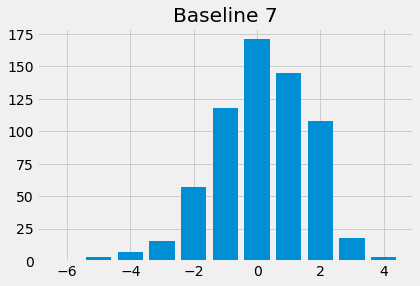

Number of correct: 171
Number of wrong: 476
Percent correct: 26%


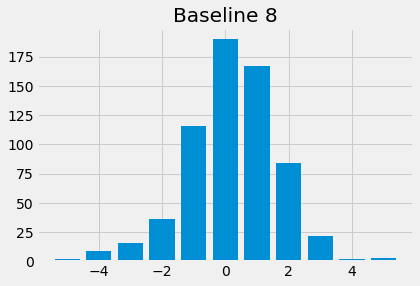

Number of correct: 190
Number of wrong: 457
Percent correct: 29%


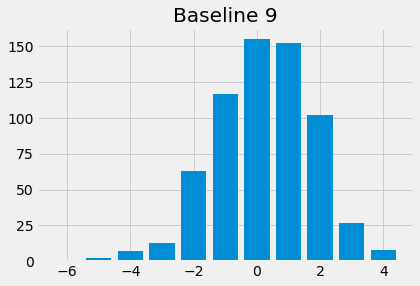

Number of correct: 155
Number of wrong: 492
Percent correct: 24%
-----------------------------------------
Average of baseline: 26.5%
-----------------------------------------


In [18]:
for i in range(n_dummy):
    plt.title('Baseline ' +  str(i))
    perc_avg_list.append(Utils.accu_plot_disc(dummy_disc[i], output_test0))

dummy_avg = np.average(perc_avg_list)
    
print('-----------------------------------------')
print('Average of baseline: ' + str(dummy_avg) + '%')
print('-----------------------------------------')

## Plot accuracy of models

-----------------------------------------
Plotting models:
-----------------------------------------


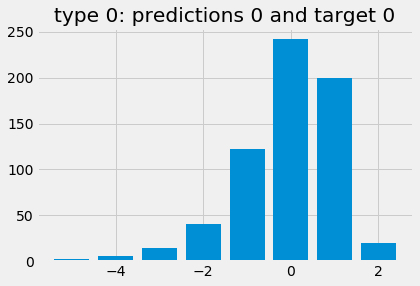

Number of correct: 242
Number of wrong: 405
Percent correct: 37%


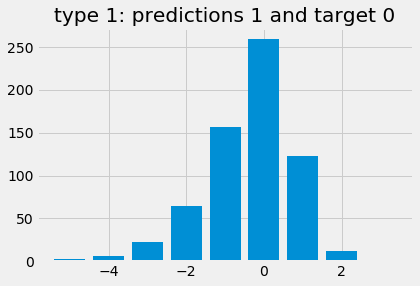

Number of correct: 259
Number of wrong: 388
Percent correct: 40%


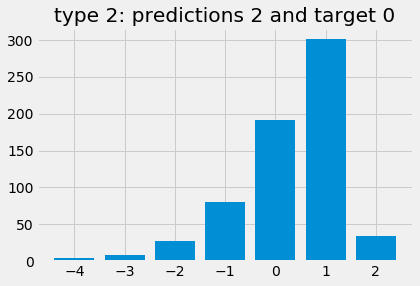

Number of correct: 191
Number of wrong: 456
Percent correct: 30%


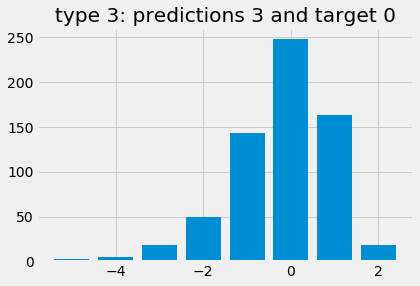

Number of correct: 248
Number of wrong: 399
Percent correct: 38%


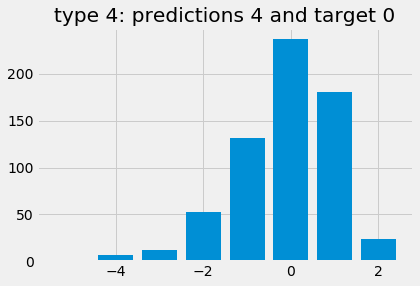

Number of correct: 237
Number of wrong: 410
Percent correct: 37%


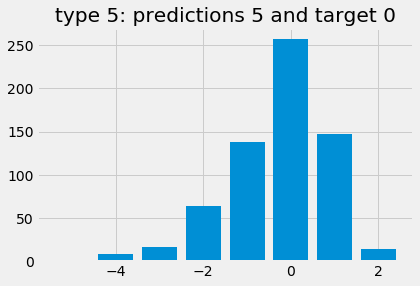

Number of correct: 257
Number of wrong: 390
Percent correct: 40%


In [19]:
print('-----------------------------------------')
print('Plotting models:')
print('-----------------------------------------')

percentage = []
n_types = 0

for i in range(n_predictors):
    for j in range(n_targets):
        title = types[n_types]
        plt.title(title)
        exec(f'percent = Utils.accu_plot_disc(modpred{i}{j}, output_test{j})')
        percentage.append(percent)
        n_types += 1

## Print summary

In [20]:
best_percentage = max(percentage)
best_per_pos = [i for i, j in enumerate(percentage) if j == best_percentage]
best_pp = ','.join(str(n) for n in best_per_pos)
diff = best_percentage - dummy_avg

In [ ]:
print('Model: Percentage list for diffent types of input:', percentage)
print('Model: Best percentage: ' + str(best_percentage) + '%')
print('Model: Best performing network type: ' + str(best_pp))
print('-----------------------------------------')
print('Baseline: Average percentage: ' + str(int(dummy_avg)) + '%')
print('-----------------------------------------')
print('Difference, baseline vs. model: ' + str(int(diff)) + '%')
print('-----------------------------------------')
print('Types:')
print('-----------------------------------------')
for line in types:
    print(line)
print('-----------------------------------------')
print('Predictors:')
print('-----------------------------------------')
for line in predict_txt:
    print(line)
print('-----------------------------------------')
print('Targets:')
print('-----------------------------------------')
for line in target_txt:
    print(line)

Model: Percentage list for diffent types of input: [37, 40, 30, 38, 37, 40]
Model: Best percentage: 40%
Model: Best performing network type: 1,5
-----------------------------------------
Baseline: Average percentage: 26%
-----------------------------------------
Difference, baseline vs. model: 13%
-----------------------------------------
Types:
-----------------------------------------
type 0: predictions 0 and target 0
type 1: predictions 1 and target 0
type 2: predictions 2 and target 0
type 3: predictions 3 and target 0
type 4: predictions 4 and target 0
type 5: predictions 5 and target 0
-----------------------------------------
Predictors:
-----------------------------------------
Data config 0: predictors0 - input values between -1 and 1
Data config 0: predictors1 - discrete input values (10 categories)
Data config 1: predictors2 - input values between -1 and 1
Data config 1: predictors3 - discrete input values (10 categories)
Data config 2: predictors4 - input values between -1

# Backup the notebook

In [ ]:
input("Press enter to backup the notebook (save first)")

In [ ]:
path = './output/' + current_file + '/'

In [ ]:
epochs = str(epochs) + early
output_file = Utils.join_list([current_file, activation, maxdays, epochs, best_percentage], '-')

In [ ]:
i = 0

type_perc = Utils.join_list(percentage, '|')
infolist = [i, best_percentage, dummy_avg, diff, best_pp, activation, maxdays, epochs, categories_out, type_perc]

out_org = Utils.org_table([infolist])

In [ ]:
%%bash -s "$current_file" "$path" "$output_file" "$out_org"
jupyter nbconvert --to html $1.ipynb
mv $1.html $2$(date +"%Y%m%d-%H%M%S")-$3.html
jupyter nbconvert --to latex $1.ipynb
mv $1.tex $2backup/$(date +"%Y%m%d-%H%M%S")-$3.tex
mv $1_files $2backup/$(date +"%Y%m%d-%H%M%S")-$3
cp $1.ipynb $2backup/notebook/$(date +"%Y%m%d-%H%M%S")-$3.ipynb
echo $4 >> $2info.org